<a href="https://colab.research.google.com/github/julius-banda/OTP/blob/master/Copy_of_MyCrack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting model training and evaluation...
Training fold 1...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 1.9251 - mae: 1.9251 - mse: 5.1697
Epoch 1: val_loss improved from inf to 2.71696, saving model to /content/drive/MyDrive/round_predictor_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 259ms/step - loss: 5.8944 - mae: 5.8944 - mse: 407.0659 - val_loss: 2.7170 - val_mae: 2.7170 - val_mse: 12.9552 - learning_rate: 0.0010
Epoch 2/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 12.0709 - mae: 12.0709 - mse: 1199.0022
Epoch 2: val_loss improved from 2.71696 to 2.69954, saving model to /content/drive/MyDrive/round_predictor_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 8.4936 - mae: 8.4936 - mse: 710.0338 - val_loss: 2.6995 - val_mae: 2.6995 - val_mse: 12.8138 - learning_rate: 0.0010
Epoch 3/200
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 3.3964 - mae: 3.3964 - mse: 48.7836
Epoch 3: val_loss improved from 2.69954 to 2.67561, saving model to /content/drive/MyDrive/round_predictor_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/ste

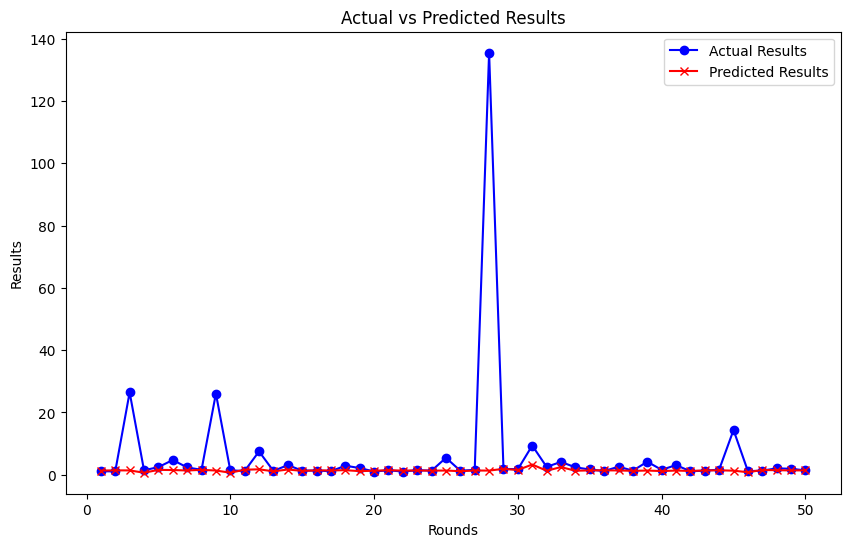


Predicting for round 51...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted result for round 51: 1.29


In [ ]:
import random
import numpy as np
import json
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define file paths (stored in Google Drive)
DATA_FILE = "/content/drive/MyDrive/round_data.json"
MODEL_FILE = "/content/drive/MyDrive/round_predictor_model.keras"

CONFIG = {
    "min_rounds": 50,
    "max_epochs": 50,  # Reduced epochs
    "batch_size": 32,  # Increased batch size
    "patience": 3,     # Early stopping patience
}

def prepare_enhanced_training_data(rounds_data, augment_data=False):
    """Prepare enhanced training data with additional features and optional augmentation."""
    X = []
    y = []
    for i in range(len(rounds_data) - 1):
        current = rounds_data[i]
        next_round = rounds_data[i + 1]

        # Additional features: rolling average, change between rounds, and log features
        rolling_avg = np.mean([rounds_data[j][0] for j in range(max(0, i-4), i+1)])  # Rolling avg of last 5 rounds
        change = current[0] - rounds_data[i - 1][0] if i > 0 else 0  # Change from previous round
        log_result = np.log(current[0] + 1)  # Log of current round result

        features = [
            current[0],  # Previous round result
            current[0]**2,  # Square of the previous result
            log_result,  # Log transformation of the previous result
            rolling_avg,  # Rolling average of past 5 rounds
            change,  # Change from previous round
        ]

        X.append(features)
        y.append(next_round[0])  # Target: Next round result

    X = np.array(X)
    y = np.array(y)

    if augment_data:
        noise = np.random.normal(0, 0.02, X.shape)  # Reduced noise factor
        X += noise  # Add noise for augmentation

    return X, y

def create_nn_model(input_shape):
    """Create and compile a neural network model."""
    model = Sequential()

    model.add(Dense(128, input_dim=input_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dropout(0.2))  # Reduced dropout

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae', 'mse'])
    return model

def incremental_training(nn_model, X_new, y_new, batch_size=CONFIG["batch_size"], epochs=5):
    """Incrementally train the model on new data."""
    nn_model.fit(X_new, y_new, epochs=epochs, batch_size=batch_size, verbose=0)
    return nn_model

def predict_next_rounds_with_nn(rounds_data):
    """Train and predict using a Neural Network model."""
    if len(rounds_data) < CONFIG["min_rounds"]:
        raise ValueError(f"A minimum of {CONFIG['min_rounds']} rounds is required for prediction.")

    X, y = prepare_enhanced_training_data(rounds_data, augment_data=False)  # Disable augmentation for initial training

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    model = create_nn_model(X_train.shape[1])

    early_stopping = EarlyStopping(monitor='val_loss', patience=CONFIG["patience"], restore_best_weights=True)
    checkpoint = ModelCheckpoint(MODEL_FILE, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

    history = model.fit(
        X_train, y_train,
        epochs=CONFIG["max_epochs"],  # Reduced epochs
        batch_size=CONFIG["batch_size"],  # Increased batch size
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"Neural Network Model Performance (Mean Absolute Error): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R^2 Score: {r2:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, scaler

def load_round_data():
    """Load the round data from file."""
    try:
        with open(DATA_FILE, "r") as file:
            return json.load(file)
    except FileNotFoundError:
        return []

def save_round_data(rounds_data):
    """Save the round data to file."""
    with open(DATA_FILE, "w") as file:
        json.dump(rounds_data, file)

def get_valid_input(prompt):
    """Helper function to get valid numeric input."""
    while True:
        try:
            result = float(input(prompt))
            return result
        except ValueError:
            print("Invalid input. Please enter a numeric value.")

def main():
    rounds_data = load_round_data()

    if len(rounds_data) < CONFIG["min_rounds"]:
        print(f"No previous data found. Please input at least {CONFIG['min_rounds']} initial results:")
        for _ in range(CONFIG["min_rounds"] - len(rounds_data)):
            result = get_valid_input("Enter result: ")
            rounds_data.append((result,))
        save_round_data(rounds_data)

    nn_model, scaler = predict_next_rounds_with_nn(rounds_data)

    round_counter = len(rounds_data) + 1

    while True:
        print(f"\nPredicting for round {round_counter}...")

        last_round_result = rounds_data[-1][0]
        rolling_avg = np.mean([rounds_data[j][0] for j in range(max(0, len(rounds_data)-5), len(rounds_data))])
        change = last_round_result - rounds_data[-2][0] if len(rounds_data) > 1 else 0
        log_result = np.log(last_round_result + 1)

        features = [
            last_round_result,
            last_round_result**2,
            log_result,
            rolling_avg,
            change,
        ]

        scaled_features = scaler.transform([features])
        predicted_result = nn_model.predict(scaled_features)[0][0]

        print(f"Predicted result for round {round_counter}: {predicted_result:.2f}")

        actual_result = get_valid_input("Enter the actual result: ")
        rounds_data.append((actual_result,))

        X_new, y_new = prepare_enhanced_training_data(rounds_data, augment_data=True)
        X_new_scaled = scaler.transform(X_new)
        nn_model = incremental_training(nn_model, X_new_scaled, y_new)

        save_round_data(rounds_data)
        nn_model.save(MODEL_FILE)

        round_counter += 1

if __name__ == "__main__":
    main()
